# PCA decomposition of VIX futures' term structure

In [1]:
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.offline as pyo
import seaborn as sns
import statsmodels.api  as sm
import statsmodels
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
from sklearn import preprocessing
import scipy as sp
import seaborn as sns
from sklearn.decomposition.pca import PCA

C:\Users\cindy\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning:

The sklearn.decomposition.pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.



### read data processed in "PCA.ipynb"

In [31]:
termseries = pd.read_csv("Data/termseries.csv")
termseries.Date = pd.to_datetime(termseries.Date)
termseries = termseries.set_index("Date")
termseries.tail()

,1M,2M,3M,4M,5M,6M,7M
Date,,,,,,,
2020-07-23,29.042857,30.655000,32.017857,29.648214,28.512857,28.666964,28.318750
2020-07-24,29.110714,30.982143,32.141071,29.950000,28.777857,28.989286,28.632143
2020-07-27,28.125000,30.490714,31.664286,29.532143,28.562143,28.737500,28.442857
2020-07-28,28.196429,30.680714,31.687500,29.576786,28.692143,28.860714,28.446429
2020-07-29,28.237500,30.754286,31.585714,29.355714,28.614000,28.816071,28.446429


### turn price series into return series

The quick hand was adapted from:

$$
Return_t=\frac{Price_t}{Price_{t-1}}-1 = Exp[\log{Price_t} - \log{Price_{t-1}}]-1
$$


In [32]:
termdiff = np.exp(np.log(termseries).diff().dropna()) - 1
termdiff.tail()

,1M,2M,3M,4M,5M,6M,7M
Date,,,,,,,
2020-07-23,0.060580,0.039530,0.026977,0.023644,0.020686,0.018365,0.019905
2020-07-24,0.002336,0.010672,0.003848,0.010179,0.009294,0.011244,0.011067
2020-07-27,-0.033861,-0.015862,-0.014834,-0.013952,-0.007496,-0.008685,-0.006611
2020-07-28,0.002540,0.006231,0.000733,0.001512,0.004551,0.004288,0.000126
2020-07-29,0.001457,0.002398,-0.003212,-0.007474,-0.002723,-0.001547,0.000000


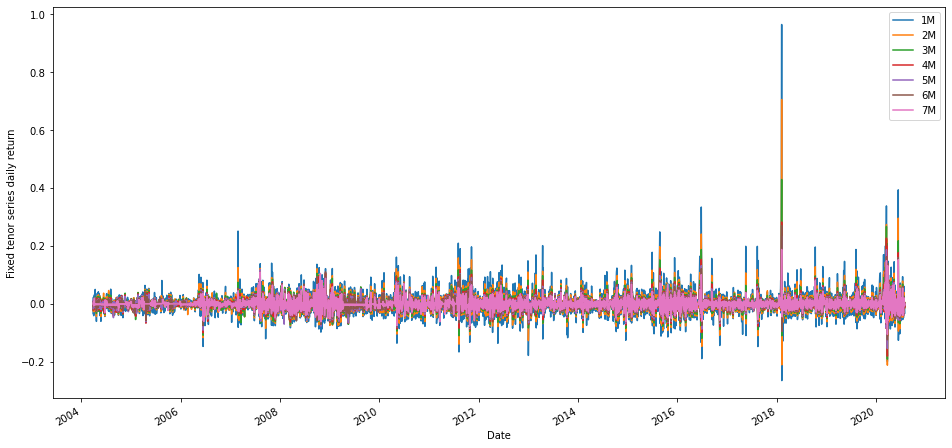

In [33]:
termdiff.plot(figsize=(16,8))
plt.ylabel("Fixed tenor series daily return")
plt.show()

### PCA of 3 components

In [34]:
pca = PCA(n_components = 3)
pca.fit(termdiff)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loadings = pd.DataFrame(data = loadings, index = termdiff.columns, columns = ["Comp 1", "Comp 2", "Comp 3"])
print(pca.explained_variance_ratio_)

[0.94555233 0.03602565 0.00862052]


#### Looks like the first 3 components will explain approx 98% of the total variance

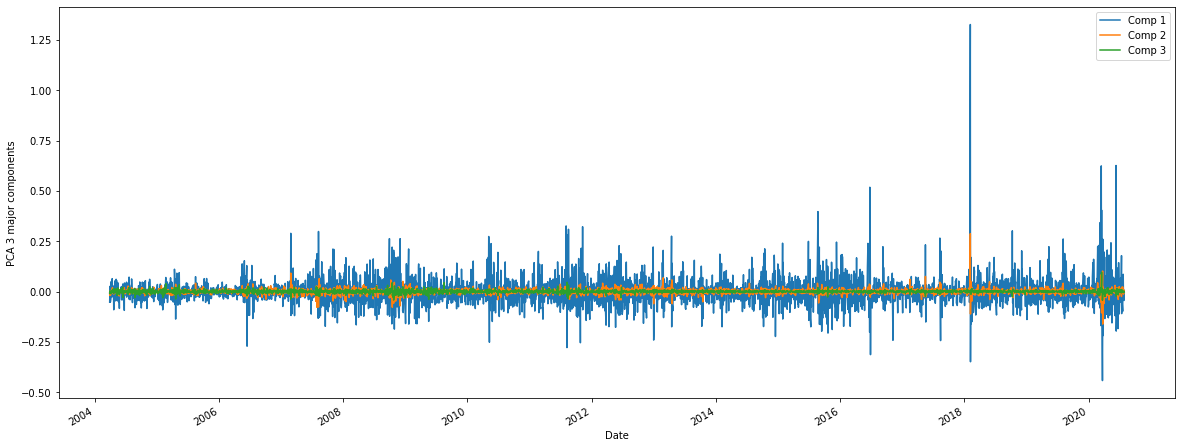

In [35]:
factors = pca.transform(termdiff)
factors_df = pd.DataFrame(data=factors, index=termdiff.index, columns=["Comp 1", "Comp 2", "Comp 3"])
factors_df.plot(figsize=(20,8))
plt.ylabel("PCA 3 major components")
plt.show()

In [36]:
reconst = pca.inverse_transform(factors)
reconst = pd.DataFrame(data=reconst, index=termdiff.index, columns = termdiff.columns)

## How good is the reconstructed time series

In [37]:
Tenor=[22,44,66,88,110,132,154]
label=['1M','2M','3M','4M','5M','6M','7M']

for testdate in np.random.choice(reconst.index, size=3, replace=False):
    ts = pd.to_datetime(str(testdate)) 
    d = ts.strftime('%Y.%m.%d')
    termPCA=reconst.loc[testdate].tolist()
    term=termdiff.dropna().loc[testdate].tolist()
    fig = go.Figure()
    fig.add_scatter(x=label, y=term,name='Original Term')
    fig.add_scatter(x=label, y=termPCA,name='PCA Term')
    fig.update_xaxes(title_text='Tenor')
    fig.update_yaxes(title_text='VIX Futures Daily Return')
    fig.update_layout(title='Term Structure (Daily Return) on '+d)
    fig.show()

## The first component

In [38]:
spot=pd.read_csv('Data/spot.csv')
spot.rename(columns={'EffectiveDate': 'Date'}, inplace=True)
spotreturn=spot
v = spot['SPX INDEX']
spotreturn["SPX Return"] = np.exp(np.log(v).diff().dropna()) - 1
spotreturn.Date=pd.to_datetime(spotreturn.Date)
spotreturn.set_index("Date", inplace=True)

In [39]:
total_frame = pd.merge(factors_df, spotreturn, on="Date", how="left")
total_frame.dropna(inplace=True)
total_frame.head()

,Comp 1,Comp 2,Comp 3,SPX INDEX,VIX INDEX,SPX Return
Date,,,,,,
2004-03-29,-0.053053,-0.005371,-0.009516,1122.47,16.50,0.013005
2004-03-30,0.002741,-0.018952,0.001709,1127.00,16.28,0.004036
2004-03-31,0.025904,0.002119,-0.004472,1126.21,16.74,-0.000701
2004-04-01,-0.006831,-0.008507,-0.008598,1132.17,16.65,0.005292
2004-04-02,-0.052604,-0.016152,0.001633,1141.81,15.64,0.008515


In [40]:
X1=total_frame["SPX Return"]
X = sm.add_constant(X1)
Y1 = total_frame["Comp 1"]
result1 = sm.OLS(Y1, X).fit()
result1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Comp 1   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     4842.
Date:                Thu, 13 Aug 2020   Prob (F-statistic):               0.00
Time:                        13:02:37   Log-Likelihood:                 6747.1
No. Observations:                4112   AIC:                        -1.349e+04
Df Residuals:                    4110   BIC:                        -1.348e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.001      1.904      0.057   -4.12e-05       0.003
SPX Return    -4.1403      0.059    -69.585      0.000      -4.257      -4.024
==============================================================================
Omnibus:                     3972.481   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1728325.481
Skew:                           3.856   Prob(JB):                         0.00
Kurtosis:                     103.140   Cond. No.                         81.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Conclusion: The first PCA component is very linearly correlated to the SPX return. So we may be able to figure out a way to hedge this exposure by holding SPX futures and VIX futures at the same time

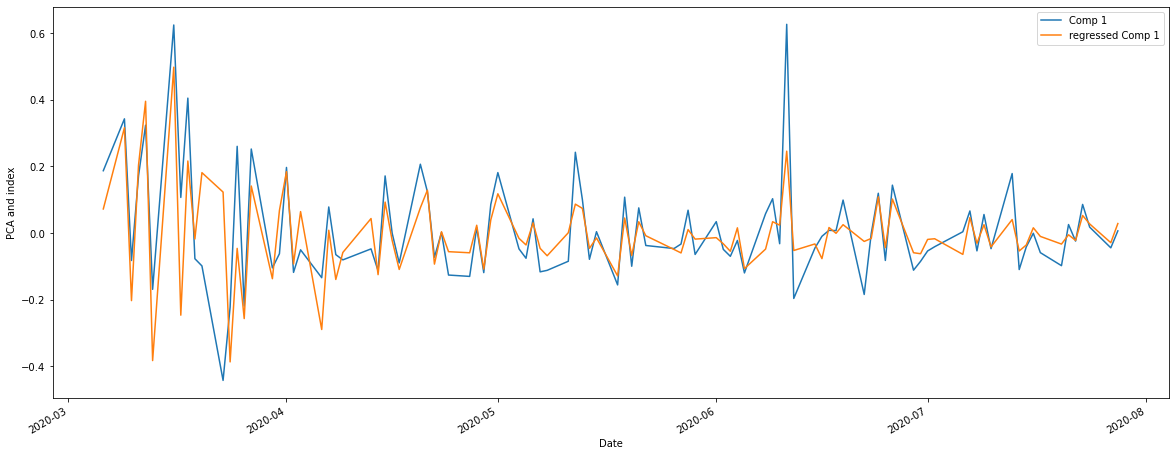

In [41]:
total_frame["regressed Comp 1"] = result1.predict(X)
total_frame[["Comp 1", "regressed Comp 1"]].iloc[-100:].plot(figsize=(20,8))
plt.ylabel("PCA and index")
plt.show()

## Steepness

It's widely known that VIX futures are in Contango shape most of the time. 

$$
Steep = \frac{VIX_{1M}}{VIX_{SPOT}}-1
$$

In [42]:
steep = termseries["2M"] / termseries["1M"] - 1
total_frame["steep"] = steep

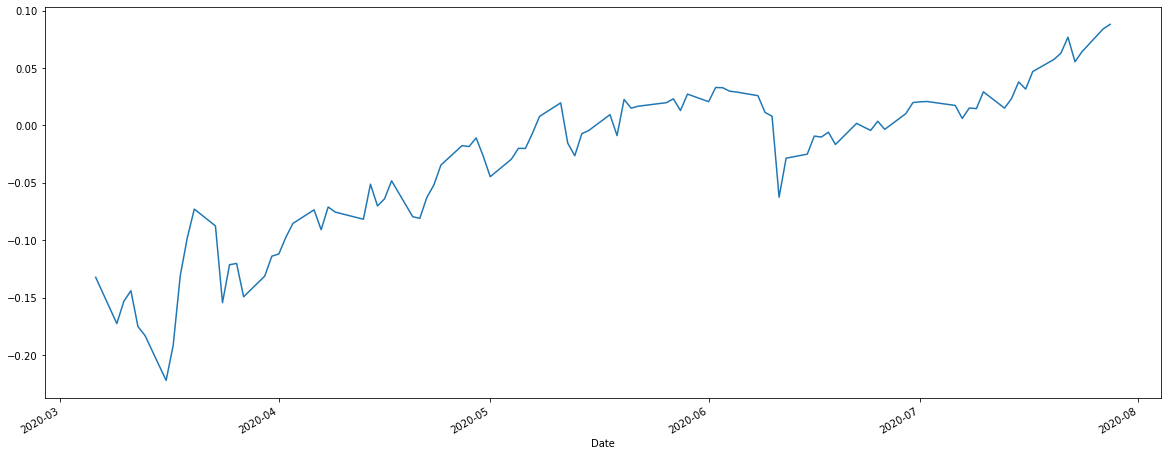

In [43]:
total_frame["steep"].iloc[-100:].plot(figsize=(20,8))

## Trading Steepness

From the chart above, it's attractive to trade this steepness:

When steep > normal range:

     $${VIX}_{1M}$$ is too expensive compared to $VIX_{SPOT}$. So we can long spot and short 1M
     
When steep < normal range:

    $VIX_{1M}$ is too cheap compared to $VIX_{SPOT}$. So we can long 1M and short spot
    
Now suppose our portfolio is $P = A*\text{V1M} + B*\text{V0M}$, say in a steepening trade we let A = 1 and B = -1. The portfolio will have exposure to components.


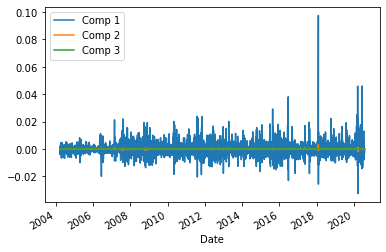

In [44]:
A = 1; B = -1;

portfolio_return  = A*termdiff["2M"] + B * termdiff["1M"]
portfolio_exposure = factors * loadings.loc["2M"].tolist() * A - factors * loadings.loc["1M"].tolist() * B
portfolio_exposure = pd.DataFrame(data=portfolio_exposure, index = termdiff.index, columns = ["Comp 1", "Comp 2", "Comp 3"])
portfolio_exposure.plot()

### Hedge by SPX

Now suppose we have 1 unit of exposure to Component 1 ( which is very linear to SPX return ), what are we going to do?

$$
1 \text{unit of Comp} 1 = -6.1828 * R_{SPX} + 0.0021
$$

So our porfolio shall become:

$$
P = A* \text{V1M} + B*\text{V0M} + C*\text{SPX}
$$

And the formula to calculate exposure is:

$$
Exp_{Comp 1} = (A * \text{Loading[V1M, Comp1]} + B * \text{Loading[V0M, Comp1]})*Comp_1 + C * R_{SPX}\\
$$

The exposure shall be offset by C * SPX
$$
Comp_1 = -6.1828 * R_{SPX} + 0.0021 \approx -6.1828*R_{SPX}\\
$$

So we have:
$$
C = (A * \text{Loading[V1M, Comp1]} + B * \text{Loading[V0M, Comp1]}) * (-6.1828)
$$

In [45]:
C = portfolio_exposure["Comp 1"] * (-6.1828)

In [46]:
hedged_portfolio_return = A*termdiff["2M"] + B * termdiff["1M"] + C * total_frame["SPX Return"]

## Trading Example 1:

From 2018-08 to 2018-12, the VIX curve term structure flattened a lot, we will long the steepness by letting B = 1 and A = -1

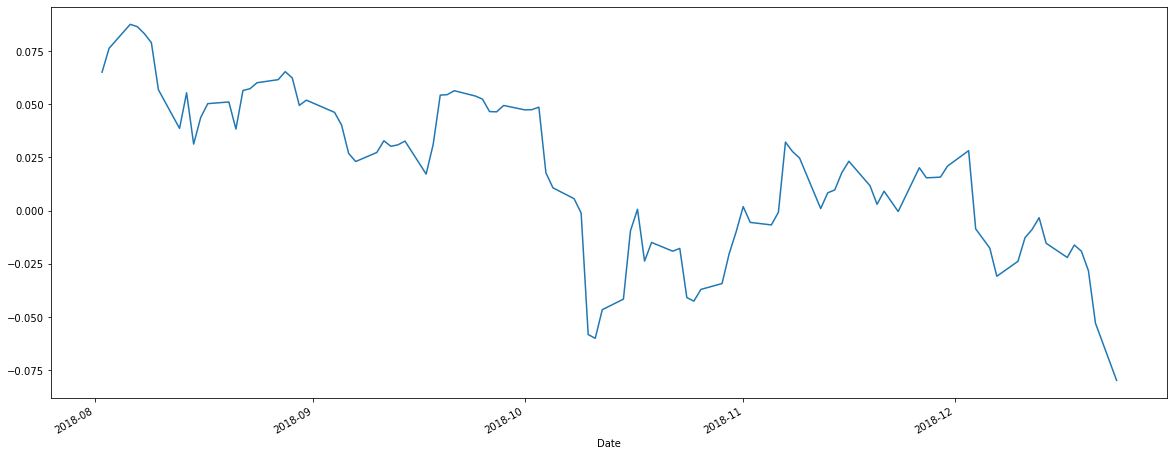

In [47]:
total_frame["steep"].iloc[-500:-400].plot(figsize=(20,8))

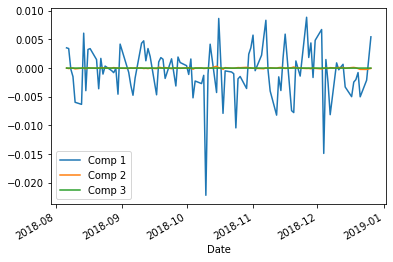

In [48]:
A = -1; B = 1;

portfolio_return  = (A*termdiff["2M"] + B * termdiff["1M"]).iloc[-500:-400]
portfolio_exposure = factors * loadings.loc["2M"].tolist() * A - factors * loadings.loc["1M"].tolist() * B
portfolio_exposure = pd.DataFrame(data=portfolio_exposure, index = termdiff.index, columns = ["Comp 1", "Comp 2", "Comp 3"]).iloc[-500:-400]
portfolio_exposure.plot()

In [49]:
C = portfolio_exposure["Comp 1"] * (-6.1828)

In [53]:
hedged_portfolio_return = (A*termdiff["2M"] + B * termdiff["1M"] + C * total_frame["SPX Return"]).iloc[-500:-400]

In [54]:
portfolio_value = np.cumprod(hedged_portfolio_return + 1)

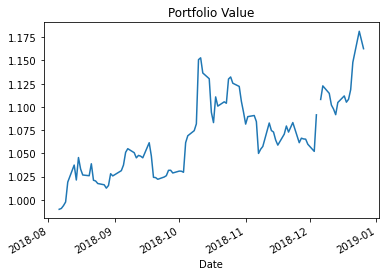

In [55]:
portfolio_value.plot()
plt.title("Portfolio Value")
plt.show()

### That's some very nice return

Problems need to solve:

1. How to roll futures? The term struture here is based on Fixed Tenor, which is not that tradable.
2. Do we really need to hedge? I think the factor's plot looks a lot like the PnL plot. Or maybe I just didn't check enough time range?

3. It's probably a good idea to check the strategy's performance during the March 2020, for the panicking market.